# Gaussian Process with PPL

In [29]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

plt.style.use("seaborn-v0_8")

In [30]:
# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X + 0.5 * jnp.sin(4.0 * X)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.3, 1.3, N_test)

    return X, Y, X_test


X, Y, X_test = get_data(N=10)

In [12]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k), obs=Y)

In [14]:
# Estimate the parameters of the model using stochastic variational inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(0.1), Trace_ELBO(), X=X, Y=Y)
svi_result = svi.run(rng_key, 1000)
params = svi_result.params
samples = guide.sample_posterior(rng_key, params, (1000,))

100%|██████████| 1000/1000 [00:00<00:00, 4759.93it/s, init loss: 21.0412, avg. loss [951-1000]: 16.0236]


In [15]:
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise


keys = random.split(rng_key_predict, samples["kernel_var"].shape[0])
vars = samples["kernel_var"]
lengths = samples["kernel_length"]
noises = samples["kernel_noise"]

means, predictions = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, Y, X_test, var, length, noise
    )
)(keys, vars, lengths, noises)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

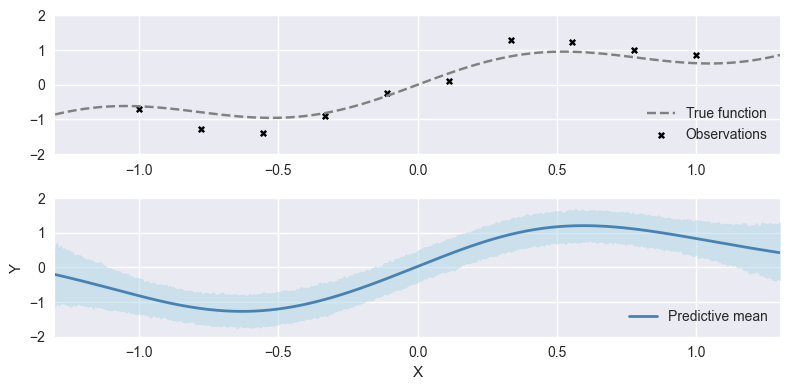

In [16]:
# Plot the result
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))

x_ = jnp.linspace(-1.3, 1.3, 100)
y_ = x_ + 0.5 * jnp.sin(4.0 * x_)
ax[0].plot(x_, y_, c="gray", ls="dashed", label="True function")
ax[0].scatter(X, Y, s=15, c="k", marker="x", label="Observations")
ax[0].set_xlim((-1.3, 1.3))
ax[0].set_ylim((-2, 2))
ax[0].legend(loc="lower right")

ax[1].fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue", alpha=0.5)
ax[1].plot(X_test, mean_prediction, c="steelblue", ls="solid", lw=2.0, label="Predictive mean")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
ax[1].set_xlim((-1.3, 1.3))
ax[1].set_ylim((-2, 2))
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

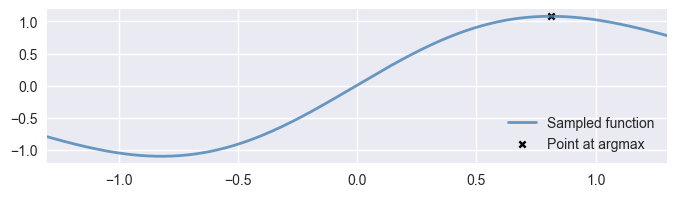

In [31]:
f = means[0]
i_star = jnp.argmax(f)
x_star = X_test[i_star]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 2))
ax.plot(X_test, f, c="steelblue", ls="solid", lw=2.0, alpha=0.8, label="Sampled function")
ax.scatter(x_star, f[i_star], s=20, c="k", marker="x", label="Point at argmax")
ax.set_xlim((-1.3, 1.3))
ax.legend(loc="lower right")
plt.show()
